In [1]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

## MobileNet <br>

https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c <br> 

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_set = MultilabelDataset(csv_path= "../../data transfer learning/train_label.csv", img_path="../../data transfer learning/train/",  transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset(csv_path= "../../data transfer learning/test_label.csv", img_path="../../data transfer learning/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=4) 

### Multiclass <br>
<img src="https://cdn.discordapp.com/attachments/969207152679993414/1065261241452482641/image.png">

### Multilabel <br>
<img src="https://cdn.discordapp.com/attachments/969207152679993414/1065261289213022249/image.png">

In [3]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

### Contoh pake pretrained-model

In [4]:
from torchvision.models import mobilenet_v2
mnet = mobilenet_v2(pretrained=True) # load pretrained model
for param in mnet.parameters(): # freeze all parameters
    param.requires_grad = False

c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
mnet.classifier[1] = nn.Linear(1280, 5) # change the last layer
mnet = mnet.to(device)

In [7]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
mnet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [9]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
class MyCustomMobileNetModule(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [11]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size,
    "output_size": len(train_set.classes),
})

## Phase 1: Adaptation (lr Standard + patience kecil)

In [12]:
model = MyCustomMobileNetModule(num_classes=config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model", early_stop_patience=2)

c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine Tuning (lr dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback .reset_early_stop()
callback.early_stop_patience = 5

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 1., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 1., 0., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [0

In [14]:
def convertToLabel(x):
  return [label for pred, label in zip(x, label2cat) if pred == 1]

def inversNorm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

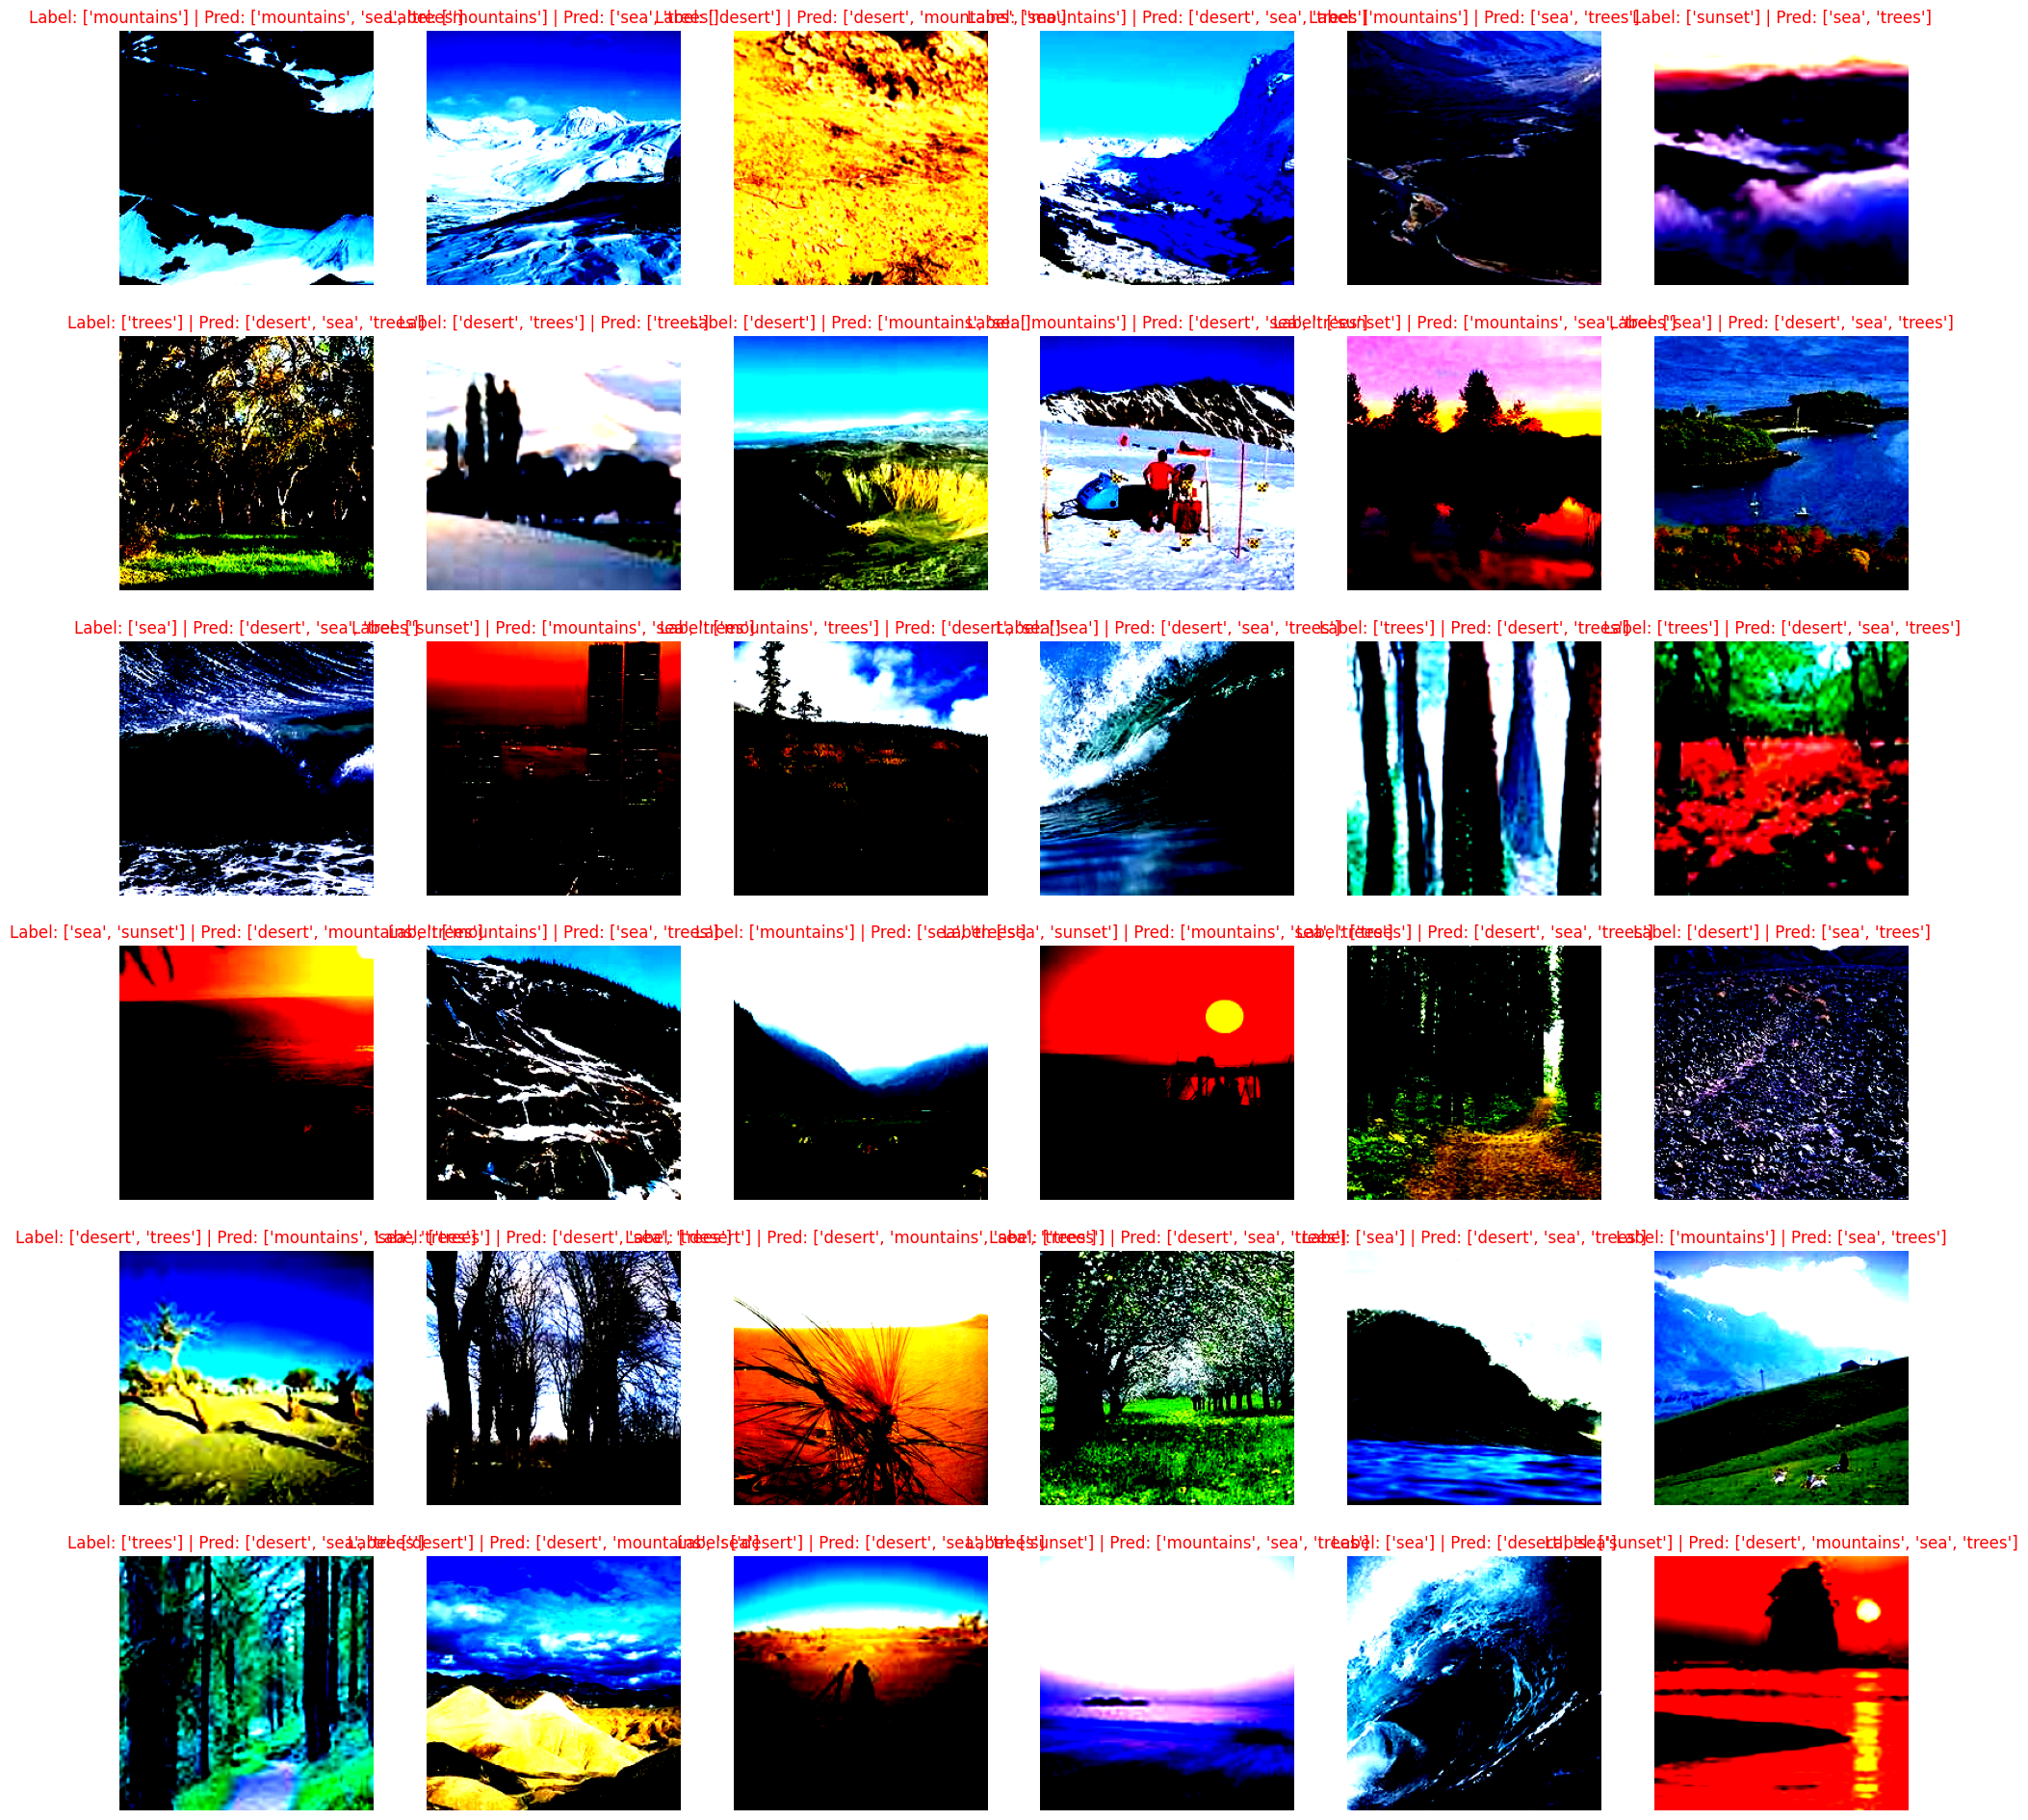

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, ax.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {'color': 'red'} if (label != pred).any() else {'color': 'green'}
  label, pred = convertToLabel(label), convertToLabel(pred)
  ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font)
  ax.axis('off');